### Jax Intro

In [185]:
import jax.numpy as jnp
from jax import grad, jit, vmap, jvp, jacfwd
from jax import random

key = random.PRNGKey(0)

import numpy as np

import plotly as ply
import plotly.graph_objects as go

### Gradients of Vector->Scalar Function
e.g) such as a neural-network loss

In [186]:
# define a vector -> scalar function
def f(x: jnp.DeviceArray) -> jnp.DeviceArray:
    return (x ** 2).sum()

In [187]:
# define a point x0=(1, 2), and the two basis vectors
# in the tangent space
x0 = jnp.array([1.0, 2.0])
v1 = jnp.array([1.0, 0.0])
v2 = jnp.array([0.0, 1.0])

# The JVP takes:
#   - a point `x0` in the input space of the function
#   - a vector in the tangent space of `x0`
# And returns:
#   - the value y = f(x)
#   - a vector in the codomain of f (the pushforward map of `v`)
# By evaluating each of the basis vectors in the tangent space, we can construct 
# the jacobian (i.e one column at a time).
y, u1 = jvp(f, (x0,), (v1,))
_, u2 = jvp(f, (x0,), (v2,))
jac = jnp.stack((u1, u2), axis=0)
jac

DeviceArray([2., 4.], dtype=float32)

In [188]:
# We can confirm this result with the inbuilt `jacfwd`
# Another way to think about this - we are taking the partial derivative of `f` with respect
# to each of its inputs. Can be done with forward or reverse mode.
jacfwd(f)(x0)

DeviceArray([2., 4.], dtype=float32)

In [189]:
# OR, equivalently...
# However, note that `grad` only works for scalar outputs!
grad(f)(x0)

DeviceArray([2., 4.], dtype=float32)

In [190]:
# The jacobian defines a tangent plane.
# e.g) for a 2-variable z = f(x,y):
# z = f(x0, y0) + f_x(x0)(x - x0) + f_y(x0)(y - y0)
def tangent(f, x0, jac):
    f0 = f(x0)
    return lambda x: f0 + (jac * (x - x0)).sum()

# get the function of the tangent plane at x0
T = tangent(f, x0, jac)

In [191]:
# create a set of linearly spaced x, y co-ordinates to evaluate the
# function and its tangent at x0
points = jnp.linspace(-7, 7, 100)
x_grid, y_grid = jnp.meshgrid(points, points)
grid_stack = jnp.stack((x_grid, y_grid), axis=2) # (100, 100, 2)
grid_flat = grid_stack.reshape([-1, 2])

In [192]:
# vectorise on batch dimension, and compile with jit
T_batch = jit(vmap(T, in_axes=0, out_axes=0))
f_batch = jit(vmap(f, in_axes=0, out_axes=0))

In [193]:
# evaluate the function at tangent function at each grid location
z = np.array(f_batch(grid_flat))
z_tangent = np.array(T_batch(grid_flat))
print(z.shape)
print(z_tangent.shape)
print(grid_flat[:, 0].shape)

(10000,)
(10000,)
(10000,)


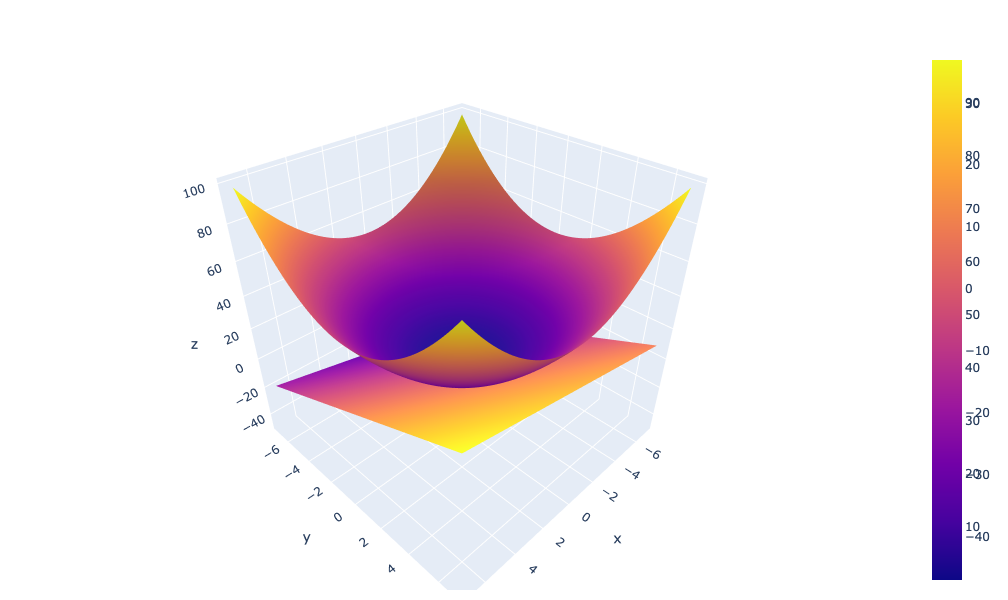

In [194]:
# visualize
x = grid_flat[:, 0].reshape([100, 100])
y = grid_flat[:, 1].reshape([100, 100])
z = z.reshape([100, 100])
z_tangent = z_tangent.reshape([100, 100])

fig = go.Figure(data = [
    go.Surface(x=x_grid, y=y_grid, z=z),
    go.Surface(x=x, y=y, z=z_tangent)
])
fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    margin=dict(l=20, r=20, b=10, t=50, pad=4),
)

fig.show()